# Mechanotransduction model in a mammalian cell

Here, we partially solve the mechanotransduction model (see mechanotransduction.ipynb for full description). In this case, we assume that the cytoskeletal activation has already been solved for, in which case we only need to solve for alterations in nuclear transport of YAP/TAZ (enhanced opening due to stretch, rupture, etc.)

The cytosolic species that must be loaded in are:
* Myo_A: activated myosin (associated with stress fiber formation)
* FActin: polymerized actin

There remain 5 or 6 species to solve for. 2 in the cytosol:
* YAPTAZ: dephosphorylated form of YAP/TAZ in the cytosol
* YAPTAZ_phos: phosphorylated form of YAP/TAZ (preferentially remains cytosolic)

The nuclear membrane species include:
* LaminA: dephosphorylated form of Lamin A, a structural componet of the nuclear lamina
* NPC_A: activated (open) nuclear pore complexes

Finally, the nucleus contains:
* YAPTAZ_nuc: concentration of YAP/TAZ in the nucleus
* YAPTAZ_nuc_phos: concentration of phosphorylated YAP/TAZ in the nucleus (only allowed when pore forms)

In [1]:
import dolfin as d
import sympy as sym
import numpy as np
import pathlib
import logging
import argparse
import matplotlib.pyplot as plt


from smart import config, mesh, model, mesh_tools
from smart.units import unit
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    sbmodel_from_locals,
)
import sys

from mech_parser_args import add_mechanotransduction_nucOnly_arguments, shape2symfraction, Shape
here = pathlib.Path.cwd()
sys.path.insert(0, (here / ".." / "scripts").as_posix())
import runner as main_run

smart_logger = logging.getLogger("smart")
smart_logger.setLevel(logging.DEBUG)
logger = logging.getLogger("mechanotransduction")
logger.setLevel(logging.INFO)
logger.info("Starting mechanotransduction example")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ROOT -2024-09-07 00:22:34,795 mechanotransduction - INFO - Starting mechanotransduction example (2904938411.py:30)


If running a series of tests, we use `argparse` to read in the test conditions. Otherwise, we load default parameters to the `args` dict.

In [2]:
# outerExpr13 = "(1 - z**4/(2000+z**4)) * (r**2 + z**2) + 0.4*(r**2 + (z+9.72)**2)*z**4 / (15 + z**4) - 169"
# innerExpr13 = "(r/5.3)**2 + ((z-9.6/2)/2.4)**2 - 1"

sys.path.insert(0, "/root/shared/gitrepos/smart-nanopillars/utils")
import spread_cell_mesh_generation as mesh_gen
parser = argparse.ArgumentParser()
# add_mechanotransduction_nucOnly_arguments(parser)
try: # run as python script on cluster
    args = vars(parser.parse_args())
except: # not a run on the cluster
    results_folder = pathlib.Path("results_newStretch_0.2width")
    args = {}
    args["outdir"] = results_folder
    args["time_step"] = 0.01
    args["pore_size"] = 0.1
    args["pore_loc"] = 0.0
    args["pore_rate"] = 10.0
    args["transport_rate"] = 10000.0
    args["transport_ratio"] = 10.0
    args["u0_npc"] = 5.0
    args["nuc_compression"] = 1.8
    args["full_sims_folder"] = pathlib.Path("/root/scratch/nanopillar-sims/results_nanopillars_indentation_newStretchCombined")
    mesh_folder = pathlib.Path(f"/root/shared/gitrepos/smart-comp-sci-data/meshes/nanopillars_new/nanopillars_indent{args['nuc_compression']}")
    args["mesh_folder"] = mesh_folder

# hEdge = 0.5
# hNP = hEdge * 0.1
full_sim_folder_cur = args["full_sims_folder"] / f"nanopillars_indent{args['nuc_compression']}_u0_{args['u0_npc']}"
nanopillars = [0.5, 3.0, 3.5]
timer = d.Timer("mechanotransduction-example")

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: --f=/root/.local/share/jupyter/runtime/kernel-v2-1296mhc1fheoUt8Z.json


Now we define units for use in the model.

In [3]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = uM * um / sec
vol_unit = uM
surf_unit = molecule / um**2
kPa = unit.kilopascal

# Model generation

For each step of model generation, refer to SMART Example 3 or API documentation for further details.

We first define compartments and the compartment container. Note that we can specify nonadjacency for surfaces in the model, which is not required, but can speed up the solution process.

In [4]:
Cyto = Compartment("Cyto", 3, um, 1)
Nuc = Compartment("Nuc", 3, um, 2)
NM = Compartment("NM", 2, um, 12)

vol_cyto = 2300  # used to compute pFAK and RhoA fluxes

Compute u_nuc

In [5]:
loaded = mesh_tools.load_mesh(args["mesh_folder"] / "spreadCell_mesh.h5")
u_nuc, aInner, bInner = mesh_gen.get_u_nuc(nanopillars[1], max(loaded.mesh.coordinates()[:,2]), 
                                           0.8, args["nuc_compression"], nanopillars)
a_nuc = mesh_gen.compute_stretch(u_nuc, aInner, bInner)
d.ALE.move(u_nuc.function_space().mesh(), u_nuc)

Now we initialize species. For comparison to ODE results, we can see well_mixed to true (fast diffusion).

In [6]:
# LaminA = Species("LaminA", 0.0, surf_unit, 0.001, D_unit, "NM")
# NPC_A = Species("NPC_A", 0.0, surf_unit, 0.001, D_unit, "NM")
YAPTAZ = Species(
    "YAPTAZ", 0.7, vol_unit, 19.0, D_unit, "Cyto"
)  # non-phosphorylated in the cytosol
YAPTAZ_phos = Species(
    "YAPTAZ_phos", 0.2, vol_unit, 19.0, D_unit, "Cyto"
)  # phosphorylated in the cytosol
YAPTAZ_nuc = Species("YAPTAZ_nuc", 0.7, vol_unit, 19.0, D_unit, "Nuc")
YAPTAZ_nuc_phos = Species("YAPTAZ_nuc_phos", 0.0, vol_unit, 19.0, D_unit, "Nuc")

Now load in the mesh.

In [7]:
parent_mesh = mesh.ParentMesh(
    mesh_filename=str(pathlib.Path(args["mesh_folder"]) / "spreadCell_mesh.h5"),
    mesh_filetype="hdf5",
    name="parent_mesh",
    curvature=pathlib.Path(args["mesh_folder"]) / "curvatures.xdmf",
    extra_keys=["subdomain0_2"]
)
# substrate_markers = parent_mesh.subdomains[0]

 2024-09-07 00:24:13,459 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: /root/shared/gitrepos/smart-comp-sci-data/meshes/nanopillars_new/nanopillars_indent1.8/spreadCell_mesh.h5! (mesh.py:245) 
 2024-09-07 00:24:14,243 smart.mesh - INFO - 1 subdomains successfully loaded from file: /root/shared/gitrepos/smart-comp-sci-data/meshes/nanopillars_new/nanopillars_indent1.8/spreadCell_mesh.h5! (mesh.py:258) 


Now we define reactions for nuclear transport. F-actin and myosin behave as spatiotemporally varying parameters here.

In [12]:
# Module C: nucleo-cytoplasmic transport
# c1: YAP/TAZ dephos. and phos. in the cytosol
k_CN = Parameter("k_CN", 0.56, 1 / sec)
k_CY = Parameter("k_CY", 0.00076, 1 / (sec * uM**2))
k_NC = Parameter("k_NC", 0.14, 1 / sec)
FActin = Parameter.from_xdmf("FActin", full_sim_folder_cur / "FActin.xdmf", uM, "Cyto")
Myo_A = Parameter.from_xdmf("Myo_A", full_sim_folder_cur / "Myo_A.xdmf", uM, "Cyto")
if args["u0_npc"] > 0:
    # uNPC = Species("uNPC", 0.0, dimensionless, 0.0, D_unit, "NM")
    uNPC = Parameter.from_xdmf("uNPC", full_sim_folder_cur / "uNPC.xdmf", dimensionless, "NM")
c1 = Reaction(
    "c1",
    ["YAPTAZ_phos"],
    ["YAPTAZ"],
    param_map={"k_CN": "k_CN", "k_CY": "k_CY", "k_NC": "k_NC", 
               "FActin": "FActin", "Myo_A": "Myo_A",},
    species_map={
        "YAPTAZ": "YAPTAZ",
        "YAPTAZ_phos": "YAPTAZ_phos",
    },
    eqn_f_str="YAPTAZ_phos*(k_CN + k_CY*FActin*Myo_A) - k_NC*YAPTAZ",
)

NPC_A = Parameter.from_xdmf("NPC_A", full_sim_folder_cur / "NPC_A.xdmf", surf_unit, "NM")

# c5: nuclear translocation of YAP/TAZ
k_insolo = Parameter("k_insolo", 1.0, surf_unit / (sec * uM))
k_in2 = Parameter("k_in2", 10.0, 1 / (sec * uM))
k_out = Parameter("k_out", 1.0, surf_unit / (sec * uM))
if args["u0_npc"] > 0:
    u0_NPC = Parameter("u0_NPC", args["u0_npc"], dimensionless)
    c5 = Reaction(
        "c5",
        ["YAPTAZ"],
        ["YAPTAZ_nuc"],
        param_map={"k_insolo": "k_insolo", "k_in2": "k_in2", "k_out": "k_out", 
                   "u0_NPC": "u0_NPC", "NPC_A": "NPC_A", "uNPC": "uNPC"},
        species_map={"YAPTAZ": "YAPTAZ", "YAPTAZ_nuc": "YAPTAZ_nuc"},
        explicit_restriction_to_domain="NM",
        eqn_f_str="YAPTAZ*exp((uNPC-1)/u0_NPC)*(k_insolo + k_in2*NPC_A) - k_out*YAPTAZ_nuc",
    )
else:
    c5 = Reaction(
        "c5",
        ["YAPTAZ"],
        ["YAPTAZ_nuc"],
        param_map={"k_insolo": "k_insolo", "k_in2": "k_in2", "k_out": "k_out", "NPC_A": "NPC_A"},
        species_map={"YAPTAZ": "YAPTAZ", "YAPTAZ_nuc": "YAPTAZ_nuc"},
        explicit_restriction_to_domain="NM",
        eqn_f_str="YAPTAZ*(k_insolo + k_in2*NPC_A) - k_out*YAPTAZ_nuc",
    )

# c7: nuclear rupture events
xPore = args["pore_loc"]
xMax = nanopillars[2]*np.round(100./nanopillars[2])
np_loc = np.linspace(0.0, xMax, int(np.round(100./nanopillars[2]))+1)
assert np.min(np.abs(xPore-np_loc)) < nanopillars[0], "Pore location should be over nanopillar"
yPore = 0.0
zPore = nanopillars[1] + 0.2
pore = Parameter.from_expression("pore", 
                                    f"(1-exp(-t/{args['pore_rate']}))*"
                                    f"exp(-(pow(x-{xPore},2)+pow(y-{yPore},2)+pow(z-{zPore},2))"
                                    f"/(pow({args['pore_size']},2)))", 
                                    dimensionless)

# c7 and c8: YAP leak due to lysis
k_inPore = Parameter("k_inPore", args["transport_ratio"]*args["transport_rate"], surf_unit / (sec * uM))
k_outPore = Parameter("k_outPore", args["transport_rate"], surf_unit / (sec * uM))
c7 = Reaction(
    "c7",
    ["YAPTAZ"],
    ["YAPTAZ_nuc"],
    param_map={"k_inPore": "k_inPore", "k_outPore": "k_outPore", "pore": "pore"},
    species_map={"YAPTAZ": "YAPTAZ", "YAPTAZ_nuc": "YAPTAZ_nuc"},
    explicit_restriction_to_domain="NM",
    eqn_f_str="YAPTAZ*pore*k_inPore - k_outPore*pore*YAPTAZ_nuc",
)
c8 = Reaction(
    "c8",
    ["YAPTAZ_phos"],
    ["YAPTAZ_nuc_phos"],
    param_map={"k_inPore": "k_inPore", "k_outPore": "k_outPore", "pore": "pore"},
    species_map={"YAPTAZ_phos": "YAPTAZ_phos", "YAPTAZ_nuc_phos": "YAPTAZ_nuc_phos"},
    explicit_restriction_to_domain="NM",
    eqn_f_str="YAPTAZ_phos*pore*k_inPore - k_outPore*pore*YAPTAZ_nuc_phos",
)

 2024-09-07 00:35:16,019 smart.model_assembly - DEBUG - Loading initial condition for FActin from file (model_assembly.py:668) 
2024-09-07 00:35:16,020 smart.model_assembly - INFO - Loading in data for parameter FActin (model_assembly.py:676) 
2024-09-07 00:35:16,020 smart.model_assembly - INFO - Parameter FActin linked to xdmf file. (model_assembly.py:700) 
 2024-09-07 00:35:16,022 smart.model_assembly - DEBUG - Loading initial condition for Myo_A from file (model_assembly.py:668) 
2024-09-07 00:35:16,022 smart.model_assembly - INFO - Loading in data for parameter Myo_A (model_assembly.py:676) 
2024-09-07 00:35:16,023 smart.model_assembly - INFO - Parameter Myo_A linked to xdmf file. (model_assembly.py:700) 
 2024-09-07 00:35:16,025 smart.model_assembly - DEBUG - Loading initial condition for uNPC from file (model_assembly.py:668) 
2024-09-07 00:35:16,026 smart.model_assembly - INFO - Loading in data for parameter uNPC (model_assembly.py:676) 
2024-09-07 00:35:16,026 smart.model_assem

In [13]:
pc, sc, cc, rc = sbmodel_from_locals(locals().values())

In [15]:
# set config for current run
configCur = config.Config()
configCur.flags.update(
    {
        "allow_unused_components": True,
    }
)
configCur.solver.update(
    {
        "final_t": 10000.0,
        "initial_dt": args["time_step"],
        "time_precision": 6,
        "use_snes": True,
        "attempt_timestep_restart_on_divergence": True,
        "reset_timestep_for_negative_solution": True,
    }
)

In [16]:
model_cur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
model_cur.initialize(initialize_solver=True)
# Write initial condition(s) to file
results = dict()
result_folder = args["outdir"]
result_folder.mkdir(exist_ok=True, parents=True)




 2024-09-07 00:35:27,348 smart.model - DEBUG - Checking validity of model (step 1 of ZZ) (model.py:256) 


2024-09-07 00:35:27,349 smart.model - DEBUG - Check that mesh/compartment dimensionalities match (model.py:347) 
2024-09-07 00:35:27,350 smart.model - DEBUG - Checking for namespace conflicts (model.py:383) 
 2024-09-07 00:35:27,351 smart.model - DEBUG - Step 1 of initialization completed successfully! (model.py:260) 



 2024-09-07 00:35:27,351 smart.model - DEBUG - Cross-Container Dependent Initializations (step 2 of ZZ) (model.py:270) 


2024-09-07 00:35:27,352 smart.model - DEBUG - Turning reactions into unsigned symbolic flux strings (model.py:436) 
2024-09-07 00:35:27,374 smart.model - DEBUG - Make sure all reactions have parameters/species defined (model.py:486) 
2024-09-07 00:35:27,380 smart.model - DEBUG - Linking parameters, species, and compartments to reactions (model.py:516) 
2024-09-07 00:35:27,381 smart.model - DEBUG - Checking for unused parameters, species, or 

*** Warning: Reading non-scalar data in HDF5 Vector





 2024-09-07 00:38:16,129 smart.model - DEBUG - Dolfin fluxes, forms, and problems+solvers (step 5 of ZZ) (model.py:327) 


2024-09-07 00:38:16,130 smart.model - DEBUG - Convert reactions to flux objects (model.py:1066) 
2024-09-07 00:38:16,130 smart.model_assembly - DEBUG - Getting fluxes for reaction c1 (model_assembly.py:1412) 
2024-09-07 00:38:16,155 smart.model_assembly - DEBUG - Getting fluxes for reaction c5 (model_assembly.py:1412) 
2024-09-07 00:38:16,163 smart.model_assembly - DEBUG - Flux c5 [YAPTAZ_nuc (f)] scaled by 0.0016605390404271648 micrometer ** 3 * micromolar / molecule (model_assembly.py:1674) 
2024-09-07 00:38:16,163 smart.model_assembly - DEBUG - Old flux units: 1 micrometer * micromolar / second (model_assembly.py:1678) 


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


2024-09-07 00:38:16,164 smart.model_assembly - DEBUG - New flux units: 1.0 micrometer * micromolar / second (model_assembly.py:1679) 
 2024-09-07 00:38:16,165 smart.model_assembly - DEBUG - DEBUGGING INTEGRATION MEASURE (only fully defined domains are enabled for now) (model_assembly.py:1711) 
2024-09-07 00:38:16,180 smart.model_assembly - DEBUG - Flux c5 [YAPTAZ (f)] scaled by 0.0016605390404271648 micrometer ** 3 * micromolar / molecule (model_assembly.py:1674) 
2024-09-07 00:38:16,181 smart.model_assembly - DEBUG - Old flux units: 1 micrometer * micromolar / second (model_assembly.py:1678) 
2024-09-07 00:38:16,182 smart.model_assembly - DEBUG - New flux units: 1.0 micrometer * micromolar / second (model_assembly.py:1679) 
 2024-09-07 00:38:16,183 smart.model_assembly - DEBUG - DEBUGGING INTEGRATION MEASURE (only fully defined domains are enabled for now) (model_assembly.py:1711) 
2024-09-07 00:38:16,191 smart.model_assembly - DEBUG - Getting fluxes for reaction c7 (model_assembly.py

2024-09-07 00:38:19,590 smart.model - DEBUG - Initial L2-norm of compartment Cyto is 0.10812461254871852 (model.py:1242) 
2024-09-07 00:38:19,677 smart.model - DEBUG - Initial L2-norm of compartment Nuc is 0.00031781336332075804 (model.py:1242) 
2024-09-07 00:38:19,678 smart.model - DEBUG - Using SNES solver (model.py:1255) 
2024-09-07 00:38:19,681 smart.solvers - DEBUG - cpu 0: (ijk)=(0, 0, 0) (143096, 143096, 143096, 143096) (solvers.py:147) 
2024-09-07 00:38:19,717 smart.solvers - DEBUG - cpu 0: (ijk)=(0, 0, 1) (143096, 143096, 143096, 143096) (solvers.py:147) 
2024-09-07 00:38:21,880 smart.solvers - DEBUG - cpu 0: (ijk)=(0, 1, 0) (143096, 6618, 143096, 6618) (solvers.py:147) 
2024-09-07 00:38:21,909 smart.solvers - DEBUG - cpu 0: (ijk)=(1, 0, 0) (6618, 143096, 6618, 143096) (solvers.py:147) 
2024-09-07 00:38:21,942 smart.solvers - DEBUG - cpu 0: (ijk)=(1, 1, 0) (6618, 6618, 6618, 6618) (solvers.py:147) 
2024-09-07 00:38:21,967 smart.solvers - DEBUG - cpu 0: (ijk)=(1, 1, 1) (6618, 6

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │  104 │                3 │      337971 │       711749 │          72874 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ Cyto        │  129 │                3 │      325665 │       688491 │          71548 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ Nuc         │  135 │                3 │       12306 │        27068 │           3309 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  3 │ NM          │  142 │                2 │        3810 │         5793 │           1984 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════

Initialize values of nuclear deformation

In [22]:
if args["u0_npc"] > 0:
    # Vcur = d.FunctionSpace(parent_mesh.dolfin_mesh, 
    #                        d.VectorElement("P", parent_mesh.dolfin_mesh.ufl_cell(), 
    #                                        degree = 1, dim = 3))
    # u_nuc_load = d.Function(Vcur)
    # u_nuc_file = d.XDMFFile(str(mesh_folder / "u_nuc.xdmf"))
    # u_nuc_file.read_checkpoint(u_nuc_load, "u_nuc", 0)
    
    uvec = uNPC.dolfin_function.vector()[:]
    NMCoords = uNPC.dolfin_function.function_space().tabulate_dof_coordinates()[:]
    rVals = np.sqrt(np.power(NMCoords[:,0],2) + np.power(NMCoords[:,1],2))
    aRad = np.max(rVals)
    aRadIdx = np.argmax(rVals)
    u_nuc_coords = u_nuc.function_space().tabulate_dof_coordinates()[0:-1:3,:]
    z0 = max(NMCoords[:,2]) - max(u_nuc_coords[:,2])
    for i in range(len(NMCoords)):
        dist_sq = (np.power(NMCoords[i][0]-u_nuc_coords[:,0],2) + 
                   np.power(NMCoords[i][1]-u_nuc_coords[:,1],2) + 
                   np.power(NMCoords[i][2]-z0-u_nuc_coords[:,2],2))
        # uvec[uNPC.dof_map[i]] = a_nuc.vector()[np.argmin(dist_sq)]
        uvec[i] = a_nuc.vector()[np.argmin(dist_sq)]
        # cur_coords = NMCoords[i]
        # cur_coords[2] -= z0
        # try:
        #     uvec[uNPC.dof_map[i]] = a_nuc(cur_coords) #u_nuc(cur_coords)[2]
        # except:
        #     uvec[uNPC.dof_map[i]] = 0.0
    # bRad = np.max(NMCoords[:,2]) - z0
    # substrate_mesh = d.create_meshview(substrate_markers, 10)
    # substrateCoords = substrate_mesh.coordinates()[:]
    # rPM = np.sqrt(np.power(substrateCoords[:,0],2) + np.power(substrateCoords[:,1],2))
    # for i in range(len(rVals)):
    #     substrateDistVals = np.sqrt(np.power(rVals[i]-rPM,2) + np.power(NMCoords[i,2]-substrateCoords[:,2],2))
    #     if np.min(substrateDistVals) < 2.0:
    #         zEllipse =  z0 - bRad*np.sqrt(1 - rVals[i]**2/aRad**2)
    #         uvec[uNPC.dof_map[i]] = NMCoords[i,2] - zEllipse
    # for tag in ["u", "n"]:
    #     uNPC.u[tag].vector().set_local(uvec)
    #     uNPC.u[tag].vector().apply("insert")
    uNPC.dolfin_function.vector().set_local(uvec)
    uNPC.dolfin_function.vector().apply("insert")

In [23]:
if model_cur.mpi_comm_world.rank == 0:
    import json
    # Dump config to results folder
    (result_folder / "config.json").write_text(
        json.dumps(
            {
                "solver": configCur.solver.__dict__,
                "flags": configCur.flags.__dict__,
                "reaction_database": configCur.reaction_database,
                "mesh_file": str(args["mesh_folder"]),
                "outdir": str(args["outdir"]),
                "time_step": args["time_step"],
            }
        )
    )

In [24]:
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(
        model_cur.mpi_comm_world, str(result_folder / f"{species_name}.xdmf")
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)
# model_cur.to_pickle(result_folder / "model_cur.pkl")

In [25]:
# Set loglevel to warning in order not to pollute notebook output
smart_logger.setLevel(logging.WARNING)
YAPTAZ_nuc_vec = np.array([model_cur.sc["YAPTAZ_nuc"].initial_condition])

In [26]:
# Solve
displayed = False
while True:
    logger.info(f"Solve for time step {model_cur.t}")
    model_cur.monolithic_solve()
    model_cur.adjust_dt()

    nucMesh = model_cur.cc["Nuc"].dolfin_mesh
    dx = d.Measure("dx", domain=nucMesh)
    int_val = d.assemble_mixed(model_cur.sc["YAPTAZ_nuc"].u["u"] * dx)
    volume = d.assemble_mixed(1.0 * dx)
    current_YAPTAZ_nuc = np.array([int_val / volume])
    YAPTAZ_nuc_vec = np.concatenate((YAPTAZ_nuc_vec, current_YAPTAZ_nuc))

    # Save results for post processing
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)

    if model_cur.mpi_comm_world.rank == 0: 
        np.savetxt(result_folder / "YAPTAZ_nuc.txt", YAPTAZ_nuc_vec.astype(np.float32))
        np.savetxt(result_folder / "tvec.txt", np.array(model_cur.tvec).astype(np.float32))
    # End if we've passed the final time
    if model_cur.t >= model_cur.final_t:
        break

ROOT -2024-09-07 02:15:07,145 mechanotransduction - INFO - Solve for time step 0.000000 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:15:30,492 mechanotransduction - INFO - Solve for time step 0.010000 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:15:53,362 mechanotransduction - INFO - Solve for time step 0.020500 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:16:16,626 mechanotransduction - INFO - Solve for time step 0.031525 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:16:39,834 mechanotransduction - INFO - Solve for time step 0.043101 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:17:03,196 mechanotransduction - INFO - Solve for time step 0.055256 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:17:26,329 mechanotransduction - INFO - Solve for time step 0.068019 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:17:49,383 mechanotransduction - INFO - Solve for time step 0.081420 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:18:12,746 mechanotransduction - INFO - Solve for time step 0.095491 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:18:35,813 mechanotransduction - INFO - Solve for time step 0.110266 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:18:48,706 mechanotransduction - INFO - Solve for time step 0.125780 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:19:12,059 mechanotransduction - INFO - Solve for time step 0.142845 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:19:34,921 mechanotransduction - INFO - Solve for time step 0.160763 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:19:58,217 mechanotransduction - INFO - Solve for time step 0.179577 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:20:11,597 mechanotransduction - INFO - Solve for time step 0.199332 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:20:24,612 mechanotransduction - INFO - Solve for time step 0.221063 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:20:37,730 mechanotransduction - INFO - Solve for time step 0.244967 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:20:50,842 mechanotransduction - INFO - Solve for time step 0.271261 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:21:04,130 mechanotransduction - INFO - Solve for time step 0.300184 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:21:17,329 mechanotransduction - INFO - Solve for time step 0.331999 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:21:30,381 mechanotransduction - INFO - Solve for time step 0.366996 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:21:43,427 mechanotransduction - INFO - Solve for time step 0.405493 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:21:56,613 mechanotransduction - INFO - Solve for time step 0.447840 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:22:09,908 mechanotransduction - INFO - Solve for time step 0.494422 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:22:22,978 mechanotransduction - INFO - Solve for time step 0.545662 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:22:36,143 mechanotransduction - INFO - Solve for time step 0.602026 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:22:49,266 mechanotransduction - INFO - Solve for time step 0.664026 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:23:02,452 mechanotransduction - INFO - Solve for time step 0.732226 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:23:15,652 mechanotransduction - INFO - Solve for time step 0.807246 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:23:39,527 mechanotransduction - INFO - Solve for time step 0.889768 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:24:03,514 mechanotransduction - INFO - Solve for time step 0.976416 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:24:27,441 mechanotransduction - INFO - Solve for time step 1.067396 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:24:51,505 mechanotransduction - INFO - Solve for time step 1.162925 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:25:15,281 mechanotransduction - INFO - Solve for time step 1.263230 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:25:39,271 mechanotransduction - INFO - Solve for time step 1.368550 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:26:03,374 mechanotransduction - INFO - Solve for time step 1.479136 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:26:27,438 mechanotransduction - INFO - Solve for time step 1.595251 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:26:51,257 mechanotransduction - INFO - Solve for time step 1.717172 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:27:15,299 mechanotransduction - INFO - Solve for time step 1.845189 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:27:39,165 mechanotransduction - INFO - Solve for time step 1.979607 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:28:03,263 mechanotransduction - INFO - Solve for time step 2.120746 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:28:27,619 mechanotransduction - INFO - Solve for time step 2.268942 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:28:51,652 mechanotransduction - INFO - Solve for time step 2.424548 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:29:15,678 mechanotransduction - INFO - Solve for time step 2.587934 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:29:40,382 mechanotransduction - INFO - Solve for time step 2.759489 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:30:04,520 mechanotransduction - INFO - Solve for time step 2.939622 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:30:29,084 mechanotransduction - INFO - Solve for time step 3.128762 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:30:53,150 mechanotransduction - INFO - Solve for time step 3.327359 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:31:17,581 mechanotransduction - INFO - Solve for time step 3.535886 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:31:42,022 mechanotransduction - INFO - Solve for time step 3.754839 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:32:06,546 mechanotransduction - INFO - Solve for time step 3.984740 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:32:30,791 mechanotransduction - INFO - Solve for time step 4.226136 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:32:55,264 mechanotransduction - INFO - Solve for time step 4.479602 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:33:19,644 mechanotransduction - INFO - Solve for time step 4.745741 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:33:43,621 mechanotransduction - INFO - Solve for time step 5.025187 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:34:07,758 mechanotransduction - INFO - Solve for time step 5.318605 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:34:31,786 mechanotransduction - INFO - Solve for time step 5.626694 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:34:56,050 mechanotransduction - INFO - Solve for time step 5.950187 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:35:20,117 mechanotransduction - INFO - Solve for time step 6.289855 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:35:44,077 mechanotransduction - INFO - Solve for time step 6.646506 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:36:08,313 mechanotransduction - INFO - Solve for time step 7.020990 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:36:32,929 mechanotransduction - INFO - Solve for time step 7.414198 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:36:56,983 mechanotransduction - INFO - Solve for time step 7.827066 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:37:10,918 mechanotransduction - INFO - Solve for time step 8.260577 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:37:35,017 mechanotransduction - INFO - Solve for time step 8.737439 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:37:59,189 mechanotransduction - INFO - Solve for time step 9.238144 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:38:23,410 mechanotransduction - INFO - Solve for time step 9.763884 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:38:47,556 mechanotransduction - INFO - Solve for time step 10.315911 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:39:11,625 mechanotransduction - INFO - Solve for time step 10.895539 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:39:35,463 mechanotransduction - INFO - Solve for time step 11.504148 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:39:59,477 mechanotransduction - INFO - Solve for time step 12.143187 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:40:23,731 mechanotransduction - INFO - Solve for time step 12.814178 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:40:47,950 mechanotransduction - INFO - Solve for time step 13.518719 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:41:12,211 mechanotransduction - INFO - Solve for time step 14.258487 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:41:36,347 mechanotransduction - INFO - Solve for time step 15.035243 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:42:00,536 mechanotransduction - INFO - Solve for time step 15.850837 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:42:25,032 mechanotransduction - INFO - Solve for time step 16.707211 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:42:49,096 mechanotransduction - INFO - Solve for time step 17.606404 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:43:13,119 mechanotransduction - INFO - Solve for time step 18.550557 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:43:37,147 mechanotransduction - INFO - Solve for time step 19.541918 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:44:01,249 mechanotransduction - INFO - Solve for time step 20.582847 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:44:25,436 mechanotransduction - INFO - Solve for time step 21.675822 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:44:49,507 mechanotransduction - INFO - Solve for time step 22.823446 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:45:13,572 mechanotransduction - INFO - Solve for time step 24.028451 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:45:37,622 mechanotransduction - INFO - Solve for time step 25.293706 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:46:01,637 mechanotransduction - INFO - Solve for time step 26.622224 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:46:25,805 mechanotransduction - INFO - Solve for time step 28.017168 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:46:49,910 mechanotransduction - INFO - Solve for time step 29.481859 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:47:14,083 mechanotransduction - INFO - Solve for time step 31.019785 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:47:38,146 mechanotransduction - INFO - Solve for time step 32.634607 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:48:02,603 mechanotransduction - INFO - Solve for time step 34.330170 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:48:26,698 mechanotransduction - INFO - Solve for time step 36.110511 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:48:50,765 mechanotransduction - INFO - Solve for time step 37.979869 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:49:14,843 mechanotransduction - INFO - Solve for time step 39.942695 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:49:38,783 mechanotransduction - INFO - Solve for time step 42.003662 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:50:03,077 mechanotransduction - INFO - Solve for time step 44.167677 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:50:27,564 mechanotransduction - INFO - Solve for time step 46.439893 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:50:51,807 mechanotransduction - INFO - Solve for time step 48.825720 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:51:16,307 mechanotransduction - INFO - Solve for time step 51.330838 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:51:40,861 mechanotransduction - INFO - Solve for time step 53.961212 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:52:05,224 mechanotransduction - INFO - Solve for time step 56.723105 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:52:29,545 mechanotransduction - INFO - Solve for time step 59.623093 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:52:53,657 mechanotransduction - INFO - Solve for time step 62.668080 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:53:18,032 mechanotransduction - INFO - Solve for time step 65.865316 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:53:42,400 mechanotransduction - INFO - Solve for time step 69.222414 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:54:06,849 mechanotransduction - INFO - Solve for time step 72.747367 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:54:31,346 mechanotransduction - INFO - Solve for time step 76.448568 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:54:55,378 mechanotransduction - INFO - Solve for time step 80.334829 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:55:19,255 mechanotransduction - INFO - Solve for time step 84.415403 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:55:43,149 mechanotransduction - INFO - Solve for time step 88.700006 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:56:07,121 mechanotransduction - INFO - Solve for time step 93.198839 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:56:31,016 mechanotransduction - INFO - Solve for time step 97.922614 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:56:54,983 mechanotransduction - INFO - Solve for time step 102.882578 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:57:18,950 mechanotransduction - INFO - Solve for time step 108.090540 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:57:42,835 mechanotransduction - INFO - Solve for time step 113.558900 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:58:07,258 mechanotransduction - INFO - Solve for time step 119.300678 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:58:31,257 mechanotransduction - INFO - Solve for time step 125.329545 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:58:55,482 mechanotransduction - INFO - Solve for time step 131.659855 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:59:19,851 mechanotransduction - INFO - Solve for time step 138.306681 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 02:59:44,097 mechanotransduction - INFO - Solve for time step 145.285848 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:00:08,363 mechanotransduction - INFO - Solve for time step 152.613973 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:00:32,661 mechanotransduction - INFO - Solve for time step 160.308504 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:00:56,833 mechanotransduction - INFO - Solve for time step 168.387762 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:01:20,996 mechanotransduction - INFO - Solve for time step 176.870983 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:01:45,192 mechanotransduction - INFO - Solve for time step 185.778365 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:02:09,390 mechanotransduction - INFO - Solve for time step 195.131116 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:02:34,034 mechanotransduction - INFO - Solve for time step 204.951505 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:02:58,422 mechanotransduction - INFO - Solve for time step 215.262913 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:03:22,784 mechanotransduction - INFO - Solve for time step 226.089891 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:03:47,191 mechanotransduction - INFO - Solve for time step 237.458218 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:04:11,735 mechanotransduction - INFO - Solve for time step 249.394961 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:04:35,825 mechanotransduction - INFO - Solve for time step 261.928541 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:05:00,024 mechanotransduction - INFO - Solve for time step 275.088800 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:05:24,181 mechanotransduction - INFO - Solve for time step 288.907072 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:05:48,508 mechanotransduction - INFO - Solve for time step 303.416258 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:06:13,011 mechanotransduction - INFO - Solve for time step 318.650903 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:06:37,217 mechanotransduction - INFO - Solve for time step 334.647280 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:07:01,414 mechanotransduction - INFO - Solve for time step 351.443476 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:07:25,624 mechanotransduction - INFO - Solve for time step 369.079482 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:07:50,208 mechanotransduction - INFO - Solve for time step 387.597288 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:08:14,382 mechanotransduction - INFO - Solve for time step 407.040984 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:08:38,865 mechanotransduction - INFO - Solve for time step 427.456865 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:09:03,074 mechanotransduction - INFO - Solve for time step 448.893540 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:09:27,224 mechanotransduction - INFO - Solve for time step 471.402049 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:09:51,380 mechanotransduction - INFO - Solve for time step 495.035983 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:10:15,513 mechanotransduction - INFO - Solve for time step 519.851614 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:10:39,568 mechanotransduction - INFO - Solve for time step 545.908027 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:11:03,712 mechanotransduction - INFO - Solve for time step 573.267261 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:11:27,569 mechanotransduction - INFO - Solve for time step 601.994457 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:11:51,415 mechanotransduction - INFO - Solve for time step 632.158013 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:12:15,359 mechanotransduction - INFO - Solve for time step 663.829747 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:12:39,410 mechanotransduction - INFO - Solve for time step 697.085068 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:13:03,454 mechanotransduction - INFO - Solve for time step 732.003155 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:13:27,494 mechanotransduction - INFO - Solve for time step 768.667146 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:13:51,441 mechanotransduction - INFO - Solve for time step 807.164337 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:14:15,728 mechanotransduction - INFO - Solve for time step 847.586388 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:14:39,536 mechanotransduction - INFO - Solve for time step 890.029542 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:15:03,959 mechanotransduction - INFO - Solve for time step 934.594854 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:15:28,440 mechanotransduction - INFO - Solve for time step 981.388432 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:15:53,047 mechanotransduction - INFO - Solve for time step 1030.521689 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:16:17,802 mechanotransduction - INFO - Solve for time step 1082.111609 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:16:42,330 mechanotransduction - INFO - Solve for time step 1136.281025 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:17:06,854 mechanotransduction - INFO - Solve for time step 1193.158912 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:17:31,343 mechanotransduction - INFO - Solve for time step 1252.880693 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:17:55,436 mechanotransduction - INFO - Solve for time step 1315.588563 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:18:19,971 mechanotransduction - INFO - Solve for time step 1381.431827 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:18:44,657 mechanotransduction - INFO - Solve for time step 1450.567254 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:19:09,726 mechanotransduction - INFO - Solve for time step 1523.159452 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:19:34,733 mechanotransduction - INFO - Solve for time step 1599.381260 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:19:59,025 mechanotransduction - INFO - Solve for time step 1679.414158 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:20:23,923 mechanotransduction - INFO - Solve for time step 1763.448701 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:20:49,068 mechanotransduction - INFO - Solve for time step 1851.684971 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:21:13,971 mechanotransduction - INFO - Solve for time step 1944.333055 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:21:38,673 mechanotransduction - INFO - Solve for time step 2041.613543 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:22:03,561 mechanotransduction - INFO - Solve for time step 2143.758055 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:22:28,192 mechanotransduction - INFO - Solve for time step 2251.009793 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:22:53,535 mechanotransduction - INFO - Solve for time step 2363.624118 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:23:18,702 mechanotransduction - INFO - Solve for time step 2481.869159 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:23:43,364 mechanotransduction - INFO - Solve for time step 2606.026452 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:24:08,042 mechanotransduction - INFO - Solve for time step 2736.391610 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:24:33,271 mechanotransduction - INFO - Solve for time step 2873.275026 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:24:58,236 mechanotransduction - INFO - Solve for time step 3017.002613 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:25:23,390 mechanotransduction - INFO - Solve for time step 3167.916579 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:25:48,417 mechanotransduction - INFO - Solve for time step 3326.376243 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:26:13,497 mechanotransduction - INFO - Solve for time step 3492.758890 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:26:38,589 mechanotransduction - INFO - Solve for time step 3667.460669 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:27:04,409 mechanotransduction - INFO - Solve for time step 3850.897537 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:27:29,740 mechanotransduction - INFO - Solve for time step 4043.506248 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:27:54,734 mechanotransduction - INFO - Solve for time step 4245.745395 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:28:19,720 mechanotransduction - INFO - Solve for time step 4458.096499 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:28:44,936 mechanotransduction - INFO - Solve for time step 4681.065158 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:29:10,402 mechanotransduction - INFO - Solve for time step 4915.182250 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:29:35,690 mechanotransduction - INFO - Solve for time step 5161.005197 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:30:00,822 mechanotransduction - INFO - Solve for time step 5419.119291 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:30:25,983 mechanotransduction - INFO - Solve for time step 5690.139090 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:30:50,909 mechanotransduction - INFO - Solve for time step 5974.709879 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:31:15,952 mechanotransduction - INFO - Solve for time step 6273.509207 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:31:52,416 mechanotransduction - INFO - Solve for time step 6587.248501 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:32:29,205 mechanotransduction - INFO - Solve for time step 6916.674760 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:33:06,085 mechanotransduction - INFO - Solve for time step 7262.572332 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:33:43,553 mechanotransduction - INFO - Solve for time step 7625.764783 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:34:20,382 mechanotransduction - INFO - Solve for time step 8007.116857 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:34:57,014 mechanotransduction - INFO - Solve for time step 8407.536535 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:35:33,625 mechanotransduction - INFO - Solve for time step 8827.977197 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:36:10,458 mechanotransduction - INFO - Solve for time step 9269.439892 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


ROOT -2024-09-07 03:36:47,146 mechanotransduction - INFO - Solve for time step 9732.975722 (2087672043.py:4)


*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector


In [27]:
logger.info("Done with solve loop")
timer.stop()
timings = d.timings(
    d.TimingClear.keep,
    [d.TimingType.wall, d.TimingType.user, d.TimingType.system],
).str(True)

ROOT -2024-09-07 03:37:12,616 mechanotransduction - INFO - Done with solve loop (96121900.py:1)


Summary of timings                           |   reps    wall avg    wall tot     usr avg  usr tot     sys avg  sys tot
-----------------------------------------------------------------------------------------------------------------------
Apply (PETScMatrix)                          |   2432   1.351e-05    0.032857  8.2237e-06     0.02           0        0
Apply (PETScVector)                          |  24035  5.6043e-06      0.1347  5.8248e-06     0.14           0        0
Assemble cells                               |      7     0.01373    0.096112    0.012857     0.09   0.0014286     0.01
Assemble system                              |      2     0.33089     0.66177        0.33     0.66           0        0
Build sparsity                               |   5690  0.00012404     0.70581  0.00013884     0.79           0        0
Compute SCOTCH graph re-ordering             |     16    0.008153     0.13045     0.00875     0.14    0.000625     0.01
Compute connectivity 0-0                

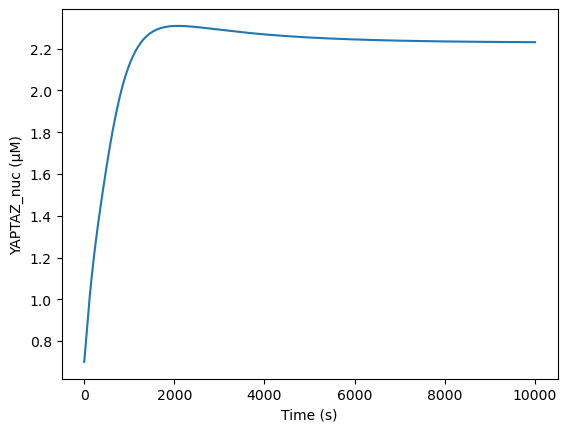

In [28]:
if model_cur.mpi_comm_world.size > 1:
    d.MPI.comm_world.Barrier()

if model_cur.mpi_comm_world.rank == 0:
    print(timings)
    (result_folder / "timings.txt").write_text(timings)
    plt.plot(model_cur.tvec, YAPTAZ_nuc_vec)
    plt.xlabel("Time (s)")
    plt.ylabel("YAPTAZ_nuc (μM)")
    plt.savefig(result_folder / "YAPTAZ_nuc.png")